In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
# global variables

look_back = 21
lead_time = 90
filename = '../../../data/Arctic_domain_mean_1979_2018 - Curated.csv'
gc_features = ['wind_10m', 'specific_humidity', 'LW_down', 'SW_down', 'rainfall', 'snowfall', 'sosaline', 't2m', 'surface_pressure', 'sea_ice_extent']

In [3]:
# from google.colab import files
# import io

# uploaded = files.upload()
# df = pd.read_csv(io.BytesIO(uploaded[filename]))
# df = df[7305:]
# df

# Reading the dataset
df = pd.read_csv(filename)
df = df[7305:]
df.head()

Day  wind_10m  specific_humidity     LW_down   SW_down  rainfall  \
7305  1/1/1999  4.987515           0.891843  183.786092  1.120906  0.700735   
7306  1/2/1999  5.075952           0.905535  183.851814  1.193514  0.712730   
7307  1/3/1999  4.931520           0.911672  184.426913  1.263909  0.677339   
7308  1/4/1999  4.761644           0.911301  187.528326  1.269229  0.824016   
7309  1/5/1999  4.739850           0.901353  187.326709  1.552208  0.926681   

      snowfall   sosaline         sst         t2m  surface_pressure  \
7305  0.501109  33.316996  273.467869  250.884060        985.112721   
7306  0.482221  33.316996  273.453826  250.359328        984.092282   
7307  0.480718  33.316996  273.454385  250.327500        982.300080   
7308  0.697950  33.316996  273.459797  249.905730        983.250565   
7309  0.835868  33.316996  273.463975  250.254873        984.247389   

      sea_ice_extent  
7305        13823248  
7306        13885522  
7307        13884279  
7308        13912624  
7309        13890148

In [4]:
df['Day'] = pd.to_datetime(df['Day'], infer_datetime_format=True)
df.set_index('Day', inplace=True)
df = df.astype(float)                 # cast df to float
df = df[gc_features]
# df.tail(len(df))

In [5]:
def create_model_data (dataset, look_back, lead_time):
    dataX, dataY = [], []
    
    for i in range(len(dataset)-look_back-lead_time):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back + (lead_time-1)])
    return np.array(dataX), np.array(dataY)

In [6]:
target_index = df.columns.tolist().index('sea_ice_extent')

dataset = df.values.astype('float32')               # DataFrame converted to Numpy Array

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

X, y = create_model_data (dataset, look_back=look_back, lead_time=lead_time)
y = y[:,target_index]

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

<function matplotlib.pyplot.show(*args, **kw)>

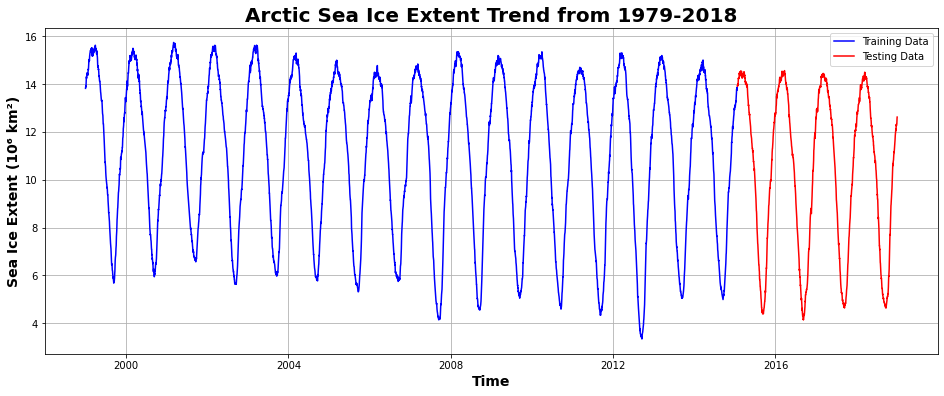

In [8]:
plt.figure(figsize = (16,6))
ax = plt.axes()
# ax.set_facecolor('#dcdcdc')

plt.title('Arctic Sea Ice Extent Trend from 1979-2018', fontsize = 20,fontweight = "bold")
plt.xlabel('Time' , fontsize = 14,fontweight = "bold")
plt.ylabel('Sea Ice Extent (10\u2076 km\u00b2)', fontsize = 14,fontweight = "bold")
plt.plot(df['sea_ice_extent'][:len(df)-len(y_test)]/10**6, 'blue', label='Training Data')
plt.plot(df['sea_ice_extent'][len(df)-len(y_test):]/10**6, 'red', label='Testing Data')
plt.legend()
plt.grid()
plt.show

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, LSTM, GRU, Dense

input_shape=(X.shape[1], X.shape[2])

model = Sequential()
model.add(GRU(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128))
model.add(Dropout(0.2))

model.add(Dense(64 ,  activation = 'relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 21, 64)            14592     
                                                                 
 dropout (Dropout)           (None, 21, 64)            0         
                                                                 
 lstm (LSTM)                 (None, 128)               98816     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 121,729
Trainable params: 121,729
Non-trai

In [10]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("weights.best.hdf5", monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='min')

callbacks_list = [checkpoint]
history = model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1, callbacks=callbacks_list, validation_split=0.1)

Epoch 1/100
74/81 [==========================>...] - ETA: 0s - loss: 0.0234 - mae: 0.1040 - mse: 0.0234

81/81 [==============================] - 10s 18ms/step - loss: 0.0220 - mae: 0.1009 - mse: 0.0220 - val_loss: 0.0019 - val_mae: 0.0355 - val_mse: 0.0019
Epoch 2/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0057 - mae: 0.0603 - mse: 0.0057

81/81 [==============================] - 1s 8ms/step - loss: 0.0057 - mae: 0.0603 - mse: 0.0057 - val_loss: 0.0012 - val_mae: 0.0246 - val_mse: 0.0012
Epoch 3/100
80/81 [============================>.] - ETA: 0s - loss: 0.0051 - mae: 0.0572 - mse: 0.0051

81/81 [==============================] - 1s 8ms/step - loss: 0.0051 - mae: 0.0572 - mse: 0.0051 - val_loss: 9.3798e-04 - val_mae: 0.0233 - val_mse: 9.3798e-04
Epoch 4/100
75/81 [==========================>...] - ETA: 0s - loss: 0.0044 - mae: 0.0531 - mse: 0.0044

81/81 [==============================] - 1s 8ms/step - loss: 0.0044 - mae: 0.0532 - mse: 0.0044 - val_loss: 0.0028 - val_mae: 0.0435 - val_mse: 0.0028
Epoch 5/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0041 - mae: 0.0512 - mse: 0.0041

81/81 [==============================] - 1s 8ms/step - loss: 0.0041 - mae: 0.0511 - mse: 0.0041 - val_loss: 0.0012 - val_mae: 0.0275 - val_mse: 0.0012
Epoch 6/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0036 - mae: 0.0486 - mse: 0.0036

81/81 [==============================] - 1s 7ms/step - loss: 0.0036 - mae: 0.0485 - mse: 0.0036 - val_loss: 0.0017 - val_mae: 0.0328 - val_mse: 0.0017
Epoch 7/100
81/81 [==============================] - ETA: 0s - loss: 0.0033 - mae: 0.0461 - mse: 0.0033

81/81 [==============================] - 1s 8ms/step - loss: 0.0033 - mae: 0.0461 - mse: 0.0033 - val_loss: 0.0020 - val_mae: 0.0365 - val_mse: 0.0020
Epoch 8/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0031 - mae: 0.0443 - mse: 0.0031

81/81 [==============================] - 1s 7ms/step - loss: 0.0031 - mae: 0.0443 - mse: 0.0031 - val_loss: 6.8153e-04 - val_mae: 0.0192 - val_mse: 6.8153e-04
Epoch 9/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0030 - mae: 0.0433 - mse: 0.0030

81/81 [==============================] - 1s 8ms/step - loss: 0.0030 - mae: 0.0434 - mse: 0.0030 - val_loss: 0.0018 - val_mae: 0.0344 - val_mse: 0.0018
Epoch 10/100
80/81 [============================>.] - ETA: 0s - loss: 0.0030 - mae: 0.0432 - mse: 0.0030

81/81 [==============================] - 1s 8ms/step - loss: 0.0030 - mae: 0.0432 - mse: 0.0030 - val_loss: 5.2925e-04 - val_mae: 0.0171 - val_mse: 5.2925e-04
Epoch 11/100
80/81 [============================>.] - ETA: 0s - loss: 0.0028 - mae: 0.0417 - mse: 0.0028

81/81 [==============================] - 1s 8ms/step - loss: 0.0028 - mae: 0.0417 - mse: 0.0028 - val_loss: 7.2099e-04 - val_mae: 0.0210 - val_mse: 7.2099e-04
Epoch 12/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0026 - mae: 0.0401 - mse: 0.0026

81/81 [==============================] - 1s 8ms/step - loss: 0.0026 - mae: 0.0401 - mse: 0.0026 - val_loss: 8.8986e-04 - val_mae: 0.0221 - val_mse: 8.8986e-04
Epoch 13/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0027 - mae: 0.0409 - mse: 0.0027

81/81 [==============================] - 1s 8ms/step - loss: 0.0027 - mae: 0.0408 - mse: 0.0027 - val_loss: 5.1188e-04 - val_mae: 0.0184 - val_mse: 5.1188e-04
Epoch 14/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0025 - mae: 0.0388 - mse: 0.0025

81/81 [==============================] - 1s 8ms/step - loss: 0.0025 - mae: 0.0389 - mse: 0.0025 - val_loss: 4.9198e-04 - val_mae: 0.0182 - val_mse: 4.9198e-04
Epoch 15/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0026 - mae: 0.0401 - mse: 0.0026

81/81 [==============================] - 1s 8ms/step - loss: 0.0026 - mae: 0.0401 - mse: 0.0026 - val_loss: 7.7698e-04 - val_mae: 0.0209 - val_mse: 7.7698e-04
Epoch 16/100
79/81 [============================>.] - ETA: 0s - loss: 0.0025 - mae: 0.0388 - mse: 0.0025

81/81 [==============================] - 1s 8ms/step - loss: 0.0025 - mae: 0.0389 - mse: 0.0025 - val_loss: 0.0018 - val_mae: 0.0334 - val_mse: 0.0018
Epoch 17/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0024 - mae: 0.0380 - mse: 0.0024

81/81 [==============================] - 1s 8ms/step - loss: 0.0024 - mae: 0.0379 - mse: 0.0024 - val_loss: 5.9064e-04 - val_mae: 0.0197 - val_mse: 5.9064e-04
Epoch 18/100
79/81 [============================>.] - ETA: 0s - loss: 0.0025 - mae: 0.0385 - mse: 0.0025

81/81 [==============================] - 1s 8ms/step - loss: 0.0025 - mae: 0.0384 - mse: 0.0025 - val_loss: 0.0011 - val_mae: 0.0262 - val_mse: 0.0011
Epoch 19/100
79/81 [============================>.] - ETA: 0s - loss: 0.0022 - mae: 0.0364 - mse: 0.0022

81/81 [==============================] - 1s 8ms/step - loss: 0.0022 - mae: 0.0365 - mse: 0.0022 - val_loss: 4.9775e-04 - val_mae: 0.0172 - val_mse: 4.9775e-04
Epoch 20/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0023 - mae: 0.0371 - mse: 0.0023

81/81 [==============================] - 1s 8ms/step - loss: 0.0023 - mae: 0.0376 - mse: 0.0023 - val_loss: 8.8872e-04 - val_mae: 0.0242 - val_mse: 8.8872e-04
Epoch 21/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0022 - mae: 0.0361 - mse: 0.0022

81/81 [==============================] - 1s 8ms/step - loss: 0.0022 - mae: 0.0361 - mse: 0.0022 - val_loss: 7.5415e-04 - val_mae: 0.0204 - val_mse: 7.5415e-04
Epoch 22/100
79/81 [============================>.] - ETA: 0s - loss: 0.0023 - mae: 0.0372 - mse: 0.0023

81/81 [==============================] - 1s 8ms/step - loss: 0.0023 - mae: 0.0372 - mse: 0.0023 - val_loss: 0.0011 - val_mae: 0.0279 - val_mse: 0.0011
Epoch 23/100
81/81 [==============================] - ETA: 0s - loss: 0.0022 - mae: 0.0367 - mse: 0.0022

81/81 [==============================] - 1s 8ms/step - loss: 0.0022 - mae: 0.0367 - mse: 0.0022 - val_loss: 6.0558e-04 - val_mae: 0.0191 - val_mse: 6.0558e-04
Epoch 24/100
81/81 [==============================] - ETA: 0s - loss: 0.0021 - mae: 0.0353 - mse: 0.0021

81/81 [==============================] - 1s 8ms/step - loss: 0.0021 - mae: 0.0353 - mse: 0.0021 - val_loss: 8.9176e-04 - val_mae: 0.0228 - val_mse: 8.9176e-04
Epoch 25/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0022 - mae: 0.0360 - mse: 0.0022

81/81 [==============================] - 1s 8ms/step - loss: 0.0022 - mae: 0.0360 - mse: 0.0022 - val_loss: 5.9857e-04 - val_mae: 0.0180 - val_mse: 5.9857e-04
Epoch 26/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0021 - mae: 0.0352 - mse: 0.0021

81/81 [==============================] - 1s 8ms/step - loss: 0.0021 - mae: 0.0352 - mse: 0.0021 - val_loss: 5.3704e-04 - val_mae: 0.0167 - val_mse: 5.3704e-04
Epoch 27/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0020 - mae: 0.0344 - mse: 0.0020

81/81 [==============================] - 1s 8ms/step - loss: 0.0020 - mae: 0.0341 - mse: 0.0020 - val_loss: 6.1104e-04 - val_mae: 0.0193 - val_mse: 6.1104e-04
Epoch 28/100
75/81 [==========================>...] - ETA: 0s - loss: 0.0019 - mae: 0.0338 - mse: 0.0019

81/81 [==============================] - 1s 8ms/step - loss: 0.0019 - mae: 0.0337 - mse: 0.0019 - val_loss: 4.7871e-04 - val_mae: 0.0169 - val_mse: 4.7871e-04
Epoch 29/100
75/81 [==========================>...] - ETA: 0s - loss: 0.0021 - mae: 0.0351 - mse: 0.0021

81/81 [==============================] - 1s 8ms/step - loss: 0.0020 - mae: 0.0350 - mse: 0.0020 - val_loss: 4.2175e-04 - val_mae: 0.0164 - val_mse: 4.2175e-04
Epoch 30/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0019 - mae: 0.0334 - mse: 0.0019

81/81 [==============================] - 1s 7ms/step - loss: 0.0019 - mae: 0.0336 - mse: 0.0019 - val_loss: 6.3910e-04 - val_mae: 0.0204 - val_mse: 6.3910e-04
Epoch 31/100
80/81 [============================>.] - ETA: 0s - loss: 0.0020 - mae: 0.0344 - mse: 0.0020

81/81 [==============================] - 1s 8ms/step - loss: 0.0020 - mae: 0.0345 - mse: 0.0020 - val_loss: 5.8342e-04 - val_mae: 0.0190 - val_mse: 5.8342e-04
Epoch 32/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0019 - mae: 0.0338 - mse: 0.0019

81/81 [==============================] - 1s 8ms/step - loss: 0.0019 - mae: 0.0338 - mse: 0.0019 - val_loss: 9.3647e-04 - val_mae: 0.0251 - val_mse: 9.3647e-04
Epoch 33/100
79/81 [============================>.] - ETA: 0s - loss: 0.0018 - mae: 0.0330 - mse: 0.0018

81/81 [==============================] - 1s 7ms/step - loss: 0.0018 - mae: 0.0329 - mse: 0.0018 - val_loss: 8.5452e-04 - val_mae: 0.0231 - val_mse: 8.5452e-04
Epoch 34/100
75/81 [==========================>...] - ETA: 0s - loss: 0.0021 - mae: 0.0353 - mse: 0.0021

81/81 [==============================] - 1s 8ms/step - loss: 0.0021 - mae: 0.0352 - mse: 0.0021 - val_loss: 7.9340e-04 - val_mae: 0.0229 - val_mse: 7.9340e-04
Epoch 35/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0019 - mae: 0.0337 - mse: 0.0019

81/81 [==============================] - 1s 8ms/step - loss: 0.0019 - mae: 0.0338 - mse: 0.0019 - val_loss: 0.0018 - val_mae: 0.0340 - val_mse: 0.0018
Epoch 36/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0018 - mae: 0.0322 - mse: 0.0018

81/81 [==============================] - 1s 8ms/step - loss: 0.0018 - mae: 0.0322 - mse: 0.0018 - val_loss: 0.0012 - val_mae: 0.0273 - val_mse: 0.0012
Epoch 37/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0019 - mae: 0.0336 - mse: 0.0019

81/81 [==============================] - 1s 8ms/step - loss: 0.0019 - mae: 0.0335 - mse: 0.0019 - val_loss: 0.0013 - val_mae: 0.0292 - val_mse: 0.0013
Epoch 38/100
75/81 [==========================>...] - ETA: 0s - loss: 0.0017 - mae: 0.0317 - mse: 0.0017

81/81 [==============================] - 1s 8ms/step - loss: 0.0017 - mae: 0.0317 - mse: 0.0017 - val_loss: 5.7134e-04 - val_mae: 0.0190 - val_mse: 5.7134e-04
Epoch 39/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0018 - mae: 0.0332 - mse: 0.0018

81/81 [==============================] - 1s 8ms/step - loss: 0.0018 - mae: 0.0330 - mse: 0.0018 - val_loss: 0.0014 - val_mae: 0.0283 - val_mse: 0.0014
Epoch 40/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0016 - mae: 0.0314 - mse: 0.0016

81/81 [==============================] - 1s 8ms/step - loss: 0.0017 - mae: 0.0315 - mse: 0.0017 - val_loss: 0.0010 - val_mae: 0.0279 - val_mse: 0.0010
Epoch 41/100
81/81 [==============================] - ETA: 0s - loss: 0.0018 - mae: 0.0321 - mse: 0.0018

81/81 [==============================] - 1s 8ms/step - loss: 0.0018 - mae: 0.0321 - mse: 0.0018 - val_loss: 6.9334e-04 - val_mae: 0.0207 - val_mse: 6.9334e-04
Epoch 42/100
75/81 [==========================>...] - ETA: 0s - loss: 0.0018 - mae: 0.0327 - mse: 0.0018

81/81 [==============================] - 1s 8ms/step - loss: 0.0018 - mae: 0.0325 - mse: 0.0018 - val_loss: 5.6768e-04 - val_mae: 0.0189 - val_mse: 5.6768e-04
Epoch 43/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0017 - mae: 0.0316 - mse: 0.0017

81/81 [==============================] - 1s 8ms/step - loss: 0.0017 - mae: 0.0316 - mse: 0.0017 - val_loss: 5.9372e-04 - val_mae: 0.0194 - val_mse: 5.9372e-04
Epoch 44/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0017 - mae: 0.0314 - mse: 0.0017

81/81 [==============================] - 1s 8ms/step - loss: 0.0017 - mae: 0.0314 - mse: 0.0017 - val_loss: 8.5312e-04 - val_mae: 0.0236 - val_mse: 8.5312e-04
Epoch 45/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0016 - mae: 0.0311 - mse: 0.0016

81/81 [==============================] - 1s 8ms/step - loss: 0.0016 - mae: 0.0311 - mse: 0.0016 - val_loss: 6.3087e-04 - val_mae: 0.0202 - val_mse: 6.3087e-04
Epoch 46/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0015 - mae: 0.0299 - mse: 0.0015

81/81 [==============================] - 1s 8ms/step - loss: 0.0015 - mae: 0.0299 - mse: 0.0015 - val_loss: 7.6866e-04 - val_mae: 0.0227 - val_mse: 7.6866e-04
Epoch 47/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0016 - mae: 0.0305 - mse: 0.0016

81/81 [==============================] - 1s 8ms/step - loss: 0.0016 - mae: 0.0306 - mse: 0.0016 - val_loss: 0.0014 - val_mae: 0.0292 - val_mse: 0.0014
Epoch 48/100
81/81 [==============================] - ETA: 0s - loss: 0.0017 - mae: 0.0312 - mse: 0.0017

81/81 [==============================] - 1s 8ms/step - loss: 0.0017 - mae: 0.0312 - mse: 0.0017 - val_loss: 5.7816e-04 - val_mae: 0.0187 - val_mse: 5.7816e-04
Epoch 49/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0016 - mae: 0.0306 - mse: 0.0016

81/81 [==============================] - 1s 8ms/step - loss: 0.0016 - mae: 0.0305 - mse: 0.0016 - val_loss: 4.8481e-04 - val_mae: 0.0169 - val_mse: 4.8481e-04
Epoch 50/100
79/81 [============================>.] - ETA: 0s - loss: 0.0016 - mae: 0.0310 - mse: 0.0016

81/81 [==============================] - 1s 8ms/step - loss: 0.0016 - mae: 0.0310 - mse: 0.0016 - val_loss: 4.8567e-04 - val_mae: 0.0186 - val_mse: 4.8567e-04
Epoch 51/100
81/81 [==============================] - ETA: 0s - loss: 0.0017 - mae: 0.0314 - mse: 0.0017

81/81 [==============================] - 1s 8ms/step - loss: 0.0017 - mae: 0.0314 - mse: 0.0017 - val_loss: 7.9884e-04 - val_mae: 0.0232 - val_mse: 7.9884e-04
Epoch 52/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0015 - mae: 0.0299 - mse: 0.0015

81/81 [==============================] - 1s 8ms/step - loss: 0.0015 - mae: 0.0300 - mse: 0.0015 - val_loss: 6.7656e-04 - val_mae: 0.0214 - val_mse: 6.7656e-04
Epoch 53/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0014 - mae: 0.0292 - mse: 0.0014

81/81 [==============================] - 1s 8ms/step - loss: 0.0014 - mae: 0.0292 - mse: 0.0014 - val_loss: 8.2835e-04 - val_mae: 0.0226 - val_mse: 8.2835e-04
Epoch 54/100
74/81 [==========================>...] - ETA: 0s - loss: 0.0016 - mae: 0.0307 - mse: 0.0016

81/81 [==============================] - 1s 8ms/step - loss: 0.0016 - mae: 0.0308 - mse: 0.0016 - val_loss: 9.1521e-04 - val_mae: 0.0258 - val_mse: 9.1521e-04
Epoch 55/100
79/81 [============================>.] - ETA: 0s - loss: 0.0016 - mae: 0.0312 - mse: 0.0016

81/81 [==============================] - 1s 7ms/step - loss: 0.0016 - mae: 0.0311 - mse: 0.0016 - val_loss: 6.3094e-04 - val_mae: 0.0198 - val_mse: 6.3094e-04
Epoch 56/100
81/81 [==============================] - ETA: 0s - loss: 0.0015 - mae: 0.0300 - mse: 0.0015

81/81 [==============================] - 1s 9ms/step - loss: 0.0015 - mae: 0.0300 - mse: 0.0015 - val_loss: 7.4528e-04 - val_mae: 0.0218 - val_mse: 7.4528e-04
Epoch 57/100
81/81 [==============================] - ETA: 0s - loss: 0.0015 - mae: 0.0294 - mse: 0.0015

81/81 [==============================] - 1s 8ms/step - loss: 0.0015 - mae: 0.0294 - mse: 0.0015 - val_loss: 6.0477e-04 - val_mae: 0.0187 - val_mse: 6.0477e-04
Epoch 58/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0015 - mae: 0.0294 - mse: 0.0015

81/81 [==============================] - 1s 8ms/step - loss: 0.0015 - mae: 0.0295 - mse: 0.0015 - val_loss: 0.0010 - val_mae: 0.0262 - val_mse: 0.0010
Epoch 59/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0014 - mae: 0.0289 - mse: 0.0014

81/81 [==============================] - 1s 8ms/step - loss: 0.0014 - mae: 0.0288 - mse: 0.0014 - val_loss: 5.4603e-04 - val_mae: 0.0192 - val_mse: 5.4603e-04
Epoch 60/100
75/81 [==========================>...] - ETA: 0s - loss: 0.0013 - mae: 0.0280 - mse: 0.0013

81/81 [==============================] - 1s 8ms/step - loss: 0.0013 - mae: 0.0280 - mse: 0.0013 - val_loss: 5.0766e-04 - val_mae: 0.0180 - val_mse: 5.0766e-04
Epoch 61/100
75/81 [==========================>...] - ETA: 0s - loss: 0.0014 - mae: 0.0290 - mse: 0.0014

81/81 [==============================] - 1s 8ms/step - loss: 0.0014 - mae: 0.0289 - mse: 0.0014 - val_loss: 8.9517e-04 - val_mae: 0.0234 - val_mse: 8.9517e-04
Epoch 62/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0015 - mae: 0.0295 - mse: 0.0015

81/81 [==============================] - 1s 8ms/step - loss: 0.0015 - mae: 0.0297 - mse: 0.0015 - val_loss: 0.0012 - val_mae: 0.0261 - val_mse: 0.0012
Epoch 63/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0015 - mae: 0.0291 - mse: 0.0015

81/81 [==============================] - 1s 8ms/step - loss: 0.0014 - mae: 0.0291 - mse: 0.0014 - val_loss: 6.8078e-04 - val_mae: 0.0205 - val_mse: 6.8078e-04
Epoch 64/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0014 - mae: 0.0288 - mse: 0.0014

81/81 [==============================] - 1s 8ms/step - loss: 0.0014 - mae: 0.0288 - mse: 0.0014 - val_loss: 6.6415e-04 - val_mae: 0.0205 - val_mse: 6.6415e-04
Epoch 65/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0013 - mae: 0.0281 - mse: 0.0013

81/81 [==============================] - 1s 8ms/step - loss: 0.0013 - mae: 0.0279 - mse: 0.0013 - val_loss: 0.0013 - val_mae: 0.0275 - val_mse: 0.0013
Epoch 66/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0013 - mae: 0.0285 - mse: 0.0013

81/81 [==============================] - 1s 8ms/step - loss: 0.0013 - mae: 0.0284 - mse: 0.0013 - val_loss: 5.5802e-04 - val_mae: 0.0184 - val_mse: 5.5802e-04
Epoch 67/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0014 - mae: 0.0289 - mse: 0.0014

81/81 [==============================] - 1s 8ms/step - loss: 0.0014 - mae: 0.0288 - mse: 0.0014 - val_loss: 0.0016 - val_mae: 0.0311 - val_mse: 0.0016
Epoch 68/100
75/81 [==========================>...] - ETA: 0s - loss: 0.0013 - mae: 0.0281 - mse: 0.0013

81/81 [==============================] - 1s 8ms/step - loss: 0.0013 - mae: 0.0280 - mse: 0.0013 - val_loss: 9.2568e-04 - val_mae: 0.0237 - val_mse: 9.2568e-04
Epoch 69/100
81/81 [==============================] - ETA: 0s - loss: 0.0013 - mae: 0.0282 - mse: 0.0013

81/81 [==============================] - 1s 8ms/step - loss: 0.0013 - mae: 0.0282 - mse: 0.0013 - val_loss: 0.0016 - val_mae: 0.0313 - val_mse: 0.0016
Epoch 70/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0014 - mae: 0.0283 - mse: 0.0014

81/81 [==============================] - 1s 8ms/step - loss: 0.0014 - mae: 0.0282 - mse: 0.0014 - val_loss: 0.0011 - val_mae: 0.0255 - val_mse: 0.0011
Epoch 71/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0013 - mae: 0.0281 - mse: 0.0013

81/81 [==============================] - 1s 8ms/step - loss: 0.0013 - mae: 0.0281 - mse: 0.0013 - val_loss: 6.5283e-04 - val_mae: 0.0204 - val_mse: 6.5283e-04
Epoch 72/100
74/81 [==========================>...] - ETA: 0s - loss: 0.0013 - mae: 0.0278 - mse: 0.0013

81/81 [==============================] - 1s 8ms/step - loss: 0.0013 - mae: 0.0277 - mse: 0.0013 - val_loss: 7.7835e-04 - val_mae: 0.0210 - val_mse: 7.7835e-04
Epoch 73/100
75/81 [==========================>...] - ETA: 0s - loss: 0.0013 - mae: 0.0276 - mse: 0.0013

81/81 [==============================] - 1s 8ms/step - loss: 0.0013 - mae: 0.0276 - mse: 0.0013 - val_loss: 5.0645e-04 - val_mae: 0.0180 - val_mse: 5.0645e-04
Epoch 74/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0012 - mae: 0.0266 - mse: 0.0012

81/81 [==============================] - 1s 8ms/step - loss: 0.0012 - mae: 0.0266 - mse: 0.0012 - val_loss: 9.4238e-04 - val_mae: 0.0242 - val_mse: 9.4238e-04
Epoch 75/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0013 - mae: 0.0277 - mse: 0.0013

81/81 [==============================] - 1s 8ms/step - loss: 0.0013 - mae: 0.0276 - mse: 0.0013 - val_loss: 0.0014 - val_mae: 0.0274 - val_mse: 0.0014
Epoch 76/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0012 - mae: 0.0268 - mse: 0.0012

81/81 [==============================] - 1s 8ms/step - loss: 0.0012 - mae: 0.0267 - mse: 0.0012 - val_loss: 9.6130e-04 - val_mae: 0.0245 - val_mse: 9.6130e-04
Epoch 77/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0012 - mae: 0.0270 - mse: 0.0012

81/81 [==============================] - 1s 8ms/step - loss: 0.0012 - mae: 0.0269 - mse: 0.0012 - val_loss: 8.1629e-04 - val_mae: 0.0221 - val_mse: 8.1629e-04
Epoch 78/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0012 - mae: 0.0265 - mse: 0.0012

81/81 [==============================] - 1s 8ms/step - loss: 0.0012 - mae: 0.0266 - mse: 0.0012 - val_loss: 0.0013 - val_mae: 0.0260 - val_mse: 0.0013
Epoch 79/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0013 - mae: 0.0278 - mse: 0.0013

81/81 [==============================] - 1s 8ms/step - loss: 0.0013 - mae: 0.0278 - mse: 0.0013 - val_loss: 0.0012 - val_mae: 0.0273 - val_mse: 0.0012
Epoch 80/100
79/81 [============================>.] - ETA: 0s - loss: 0.0012 - mae: 0.0268 - mse: 0.0012

81/81 [==============================] - 1s 8ms/step - loss: 0.0012 - mae: 0.0268 - mse: 0.0012 - val_loss: 5.3028e-04 - val_mae: 0.0180 - val_mse: 5.3028e-04
Epoch 81/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0011 - mae: 0.0257 - mse: 0.0011

81/81 [==============================] - 1s 8ms/step - loss: 0.0011 - mae: 0.0256 - mse: 0.0011 - val_loss: 8.1443e-04 - val_mae: 0.0214 - val_mse: 8.1443e-04
Epoch 82/100
79/81 [============================>.] - ETA: 0s - loss: 0.0012 - mae: 0.0271 - mse: 0.0012

81/81 [==============================] - 1s 8ms/step - loss: 0.0012 - mae: 0.0272 - mse: 0.0012 - val_loss: 0.0011 - val_mae: 0.0254 - val_mse: 0.0011
Epoch 83/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0012 - mae: 0.0269 - mse: 0.0012

81/81 [==============================] - 1s 8ms/step - loss: 0.0012 - mae: 0.0269 - mse: 0.0012 - val_loss: 0.0010 - val_mae: 0.0247 - val_mse: 0.0010
Epoch 84/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0011 - mae: 0.0263 - mse: 0.0011

81/81 [==============================] - 1s 8ms/step - loss: 0.0011 - mae: 0.0263 - mse: 0.0011 - val_loss: 0.0015 - val_mae: 0.0305 - val_mse: 0.0015
Epoch 85/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0013 - mae: 0.0277 - mse: 0.0013

81/81 [==============================] - 1s 8ms/step - loss: 0.0013 - mae: 0.0276 - mse: 0.0013 - val_loss: 6.4370e-04 - val_mae: 0.0191 - val_mse: 6.4370e-04
Epoch 86/100
80/81 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0257 - mse: 0.0011

81/81 [==============================] - 1s 8ms/step - loss: 0.0011 - mae: 0.0256 - mse: 0.0011 - val_loss: 0.0010 - val_mae: 0.0257 - val_mse: 0.0010
Epoch 87/100
81/81 [==============================] - ETA: 0s - loss: 0.0012 - mae: 0.0266 - mse: 0.0012

81/81 [==============================] - 1s 8ms/step - loss: 0.0012 - mae: 0.0266 - mse: 0.0012 - val_loss: 9.1771e-04 - val_mae: 0.0244 - val_mse: 9.1771e-04
Epoch 88/100
77/81 [===========================>..] - ETA: 0s - loss: 9.9341e-04 - mae: 0.0244 - mse: 9.9341e-04

81/81 [==============================] - 1s 9ms/step - loss: 9.9576e-04 - mae: 0.0245 - mse: 9.9576e-04 - val_loss: 6.8762e-04 - val_mae: 0.0196 - val_mse: 6.8762e-04
Epoch 89/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0010 - mae: 0.0245 - mse: 0.0010

81/81 [==============================] - 1s 8ms/step - loss: 0.0010 - mae: 0.0246 - mse: 0.0010 - val_loss: 0.0014 - val_mae: 0.0274 - val_mse: 0.0014
Epoch 90/100
76/81 [===========================>..] - ETA: 0s - loss: 9.9238e-04 - mae: 0.0245 - mse: 9.9238e-04

81/81 [==============================] - 1s 8ms/step - loss: 9.8113e-04 - mae: 0.0244 - mse: 9.8113e-04 - val_loss: 0.0012 - val_mae: 0.0262 - val_mse: 0.0012
Epoch 91/100
74/81 [==========================>...] - ETA: 0s - loss: 0.0010 - mae: 0.0250 - mse: 0.0010

81/81 [==============================] - 1s 8ms/step - loss: 0.0010 - mae: 0.0248 - mse: 0.0010 - val_loss: 0.0018 - val_mae: 0.0332 - val_mse: 0.0018
Epoch 92/100
79/81 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0259 - mse: 0.0011

81/81 [==============================] - 1s 8ms/step - loss: 0.0011 - mae: 0.0260 - mse: 0.0011 - val_loss: 8.2819e-04 - val_mae: 0.0214 - val_mse: 8.2819e-04
Epoch 93/100
77/81 [===========================>..] - ETA: 0s - loss: 9.6368e-04 - mae: 0.0244 - mse: 9.6368e-04

81/81 [==============================] - 1s 8ms/step - loss: 9.6484e-04 - mae: 0.0244 - mse: 9.6484e-04 - val_loss: 0.0011 - val_mae: 0.0244 - val_mse: 0.0011
Epoch 94/100
76/81 [===========================>..] - ETA: 0s - loss: 9.6713e-04 - mae: 0.0243 - mse: 9.6713e-04

81/81 [==============================] - 1s 8ms/step - loss: 9.9297e-04 - mae: 0.0245 - mse: 9.9297e-04 - val_loss: 7.1968e-04 - val_mae: 0.0198 - val_mse: 7.1968e-04
Epoch 95/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0011 - mae: 0.0259 - mse: 0.0011

81/81 [==============================] - 1s 8ms/step - loss: 0.0011 - mae: 0.0259 - mse: 0.0011 - val_loss: 0.0014 - val_mae: 0.0275 - val_mse: 0.0014
Epoch 96/100
80/81 [============================>.] - ETA: 0s - loss: 9.5484e-04 - mae: 0.0241 - mse: 9.5484e-04

81/81 [==============================] - 1s 8ms/step - loss: 9.5520e-04 - mae: 0.0241 - mse: 9.5520e-04 - val_loss: 0.0011 - val_mae: 0.0251 - val_mse: 0.0011
Epoch 97/100
76/81 [===========================>..] - ETA: 0s - loss: 8.4409e-04 - mae: 0.0228 - mse: 8.4409e-04

81/81 [==============================] - 1s 8ms/step - loss: 8.3642e-04 - mae: 0.0227 - mse: 8.3642e-04 - val_loss: 0.0013 - val_mae: 0.0258 - val_mse: 0.0013
Epoch 98/100
79/81 [============================>.] - ETA: 0s - loss: 8.8140e-04 - mae: 0.0232 - mse: 8.8140e-04

81/81 [==============================] - 1s 8ms/step - loss: 8.7746e-04 - mae: 0.0232 - mse: 8.7746e-04 - val_loss: 9.0696e-04 - val_mae: 0.0221 - val_mse: 9.0696e-04
Epoch 99/100
75/81 [==========================>...] - ETA: 0s - loss: 9.2777e-04 - mae: 0.0239 - mse: 9.2777e-04

81/81 [==============================] - 1s 8ms/step - loss: 9.3128e-04 - mae: 0.0240 - mse: 9.3128e-04 - val_loss: 9.6787e-04 - val_mae: 0.0233 - val_mse: 9.6787e-04
Epoch 100/100
75/81 [==========================>...] - ETA: 0s - loss: 8.8712e-04 - mae: 0.0232 - mse: 8.8712e-04

81/81 [==============================] - 1s 8ms/step - loss: 8.8135e-04 - mae: 0.0231 - mse: 8.8135e-04 - val_loss: 0.0011 - val_mae: 0.0241 - val_mse: 0.0011


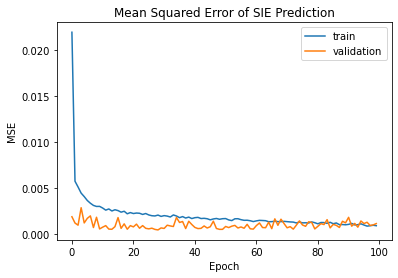

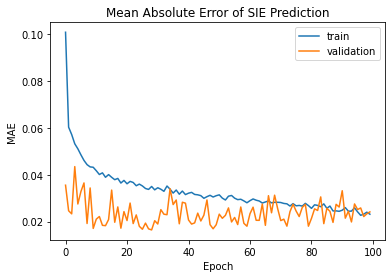

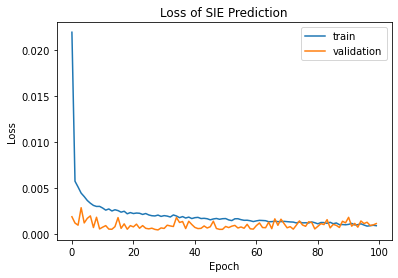

In [11]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Mean Squared Error of SIE Prediction')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Mean Absolute Error of SIE Prediction')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss of SIE Prediction')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from numpy import sqrt

#model.load_weights("weights.best.hdf5")

cols = len(df.columns)
pred = model.predict(X_test)

predicted_dataset = dataset
predicted_dataset[len(predicted_dataset)-len(pred):, cols-1] = pred[:, 0]
scaled_predicted_dataset = scaler.inverse_transform(predicted_dataset)

predicted_df = df.copy()
predicted_df['sea_ice_extent'][len(predicted_dataset)-len(pred):] = scaled_predicted_dataset[len(predicted_dataset)-len(pred):, cols-1]

predictions = pd.DataFrame()
predictions['predicted'] = (predicted_df['sea_ice_extent'][len(predicted_dataset)-len(pred):])
predictions['actual'] = (df['sea_ice_extent'][len(predicted_dataset)-len(pred):])
predictions = predictions.astype(float)

45/45 [==============================] - 1s 3ms/step


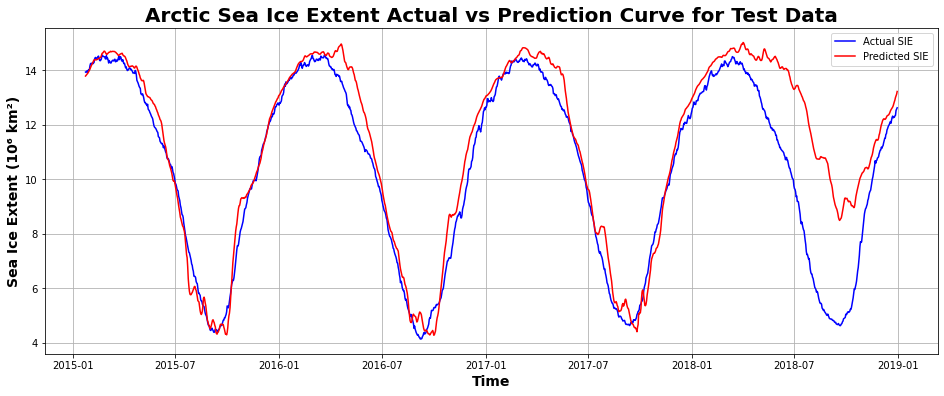

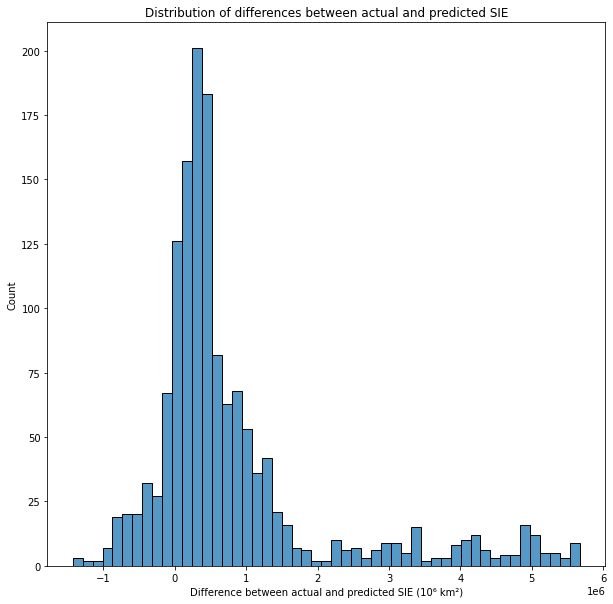

MSE :  2378963582172.233 (10⁶ km²)
MSPE : 5.944101311740186 %
RMSE :  1542388.9205295248 (10⁶ km²)
RMSPE : 24.38052770499479 %
MAE :  927690.181028492 (10⁶ km²)
MAPE :  8.883210854237522 %
R2 :  0.785497299069377


In [13]:
plt.figure(figsize = (16,6))
ax = plt.axes()
# ax.set_facecolor('#dcdcdc')

plt.title('Arctic Sea Ice Extent Actual vs Prediction Curve for Test Data', fontsize = 20,fontweight = "bold")
plt.xlabel('Time' , fontsize = 14,fontweight = "bold")
plt.ylabel('Sea Ice Extent (10\u2076 km\u00b2)', fontsize = 14,fontweight = "bold")
plt.plot(predictions['actual']/10**6, 'blue', label='Actual SIE')
plt.plot(predictions['predicted']/10**6, 'red', label='Predicted SIE')
plt.legend()
plt.grid()
plt.show

predictions['diff'] = predictions['predicted'] - predictions['actual']
plt.figure(figsize=(10,10))
plt.xlabel('Difference between actual and predicted SIE (10\u2076 km\u00b2)')
sns.histplot(predictions['diff'])
plt.title('Distribution of differences between actual and predicted SIE')
plt.show()

mspe = (np.mean(np.square((predictions['actual'].values - predictions['predicted'].values) / predictions['actual'].values))) * 100
rmspe = (np.sqrt(np.mean(np.square((predictions['actual'].values - predictions['predicted'].values) / predictions['actual'].values)))) * 100

print("MSE : ", mean_squared_error(predictions['predicted'].values, predictions['actual'].values), "(10\u2076 km\u00b2)")
print("MSPE :", mspe, "%")
print("RMSE : ", sqrt(mean_squared_error(predictions['predicted'].values, predictions['actual'].values)), "(10\u2076 km\u00b2)")
print("RMSPE :", rmspe, "%")
print("MAE : ", mean_absolute_error(predictions['predicted'].values, predictions['actual'].values), "(10\u2076 km\u00b2)")
print("MAPE : ", mean_absolute_percentage_error(predictions['predicted'].values, predictions['actual'].values)*100, "%")
print("R2 : ", r2_score(predictions['predicted'].values, predictions['actual'].values))

In [14]:
# while True:pass